<a href="https://colab.research.google.com/github/arquansa/PSTB-exercises/blob/main/W7D5DC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Daily Challenge : Text summarization using NLP


Introduction
This notebook demonstrates a practical application of Natural Language Processing (NLP) techniques to automatically generate summaries of text documents. We will explore how to preprocess text data, represent words and sentences as vectors, and leverage graph-based algorithms to identify the most important sentences for summarization.



👩‍🏫 👩🏿‍🏫 What You’ll learn
Text Preprocessing: Techniques for cleaning and preparing text data, including tokenization, stop word removal, and converting text to lowercase.
Word Embeddings: Understanding and using pre-trained word embeddings like GloVe to represent words as dense vectors.
Sentence Vectorization: Creating vector representations of sentences by aggregating word embeddings.
Similarity Measures: Using cosine similarity to determine the semantic similarity between sentences.
Graph-Based Summarization: Applying the PageRank algorithm on a graph of sentence similarities to rank sentence importance.
Text Summarization Implementation: Combining these techniques to build a text summarization system.


🛠️ What you will create
You will create an automatic text summarization system that can take a collection of tennis articles as input and generate a concise summary highlighting the key information.



Task
1. Data Loading and Inspection

Load the tennis articles dataset from the .xls file using pandas.
Explore the dataset using .head() and .info() to understand its structure.
Drop the article_title column to simplify the dataset.
2. Sentence Tokenization

Use nltk.sent_tokenize() to split the article_text into individual sentences.
Flatten the resulting list of sentence lists into a single list of all sentences.
3. Download and Load GloVe Word Embeddings

Download the pre-trained GloVe vectors (e.g., glove.6B.100d.txt).
Load the embeddings into a Python dictionary where each word maps to its 100-dimensional vector.
4. Text Cleaning and Normalization

Remove punctuation, special characters, and numbers using regex.
Convert all sentences to lowercase to avoid case-sensitive mismatch.
Remove stop words using nltk.corpus.stopwords to reduce noise in the data.
5. Sentence Vectorization

For each cleaned sentence:
Split into words.
Replace each word with its GloVe vector (use a zero-vector if the word is not in the embedding).
Compute the average of all word vectors in the sentence.
Store all resulting sentence vectors in a list.
6. Similarity Matrix Construction

Initialize an empty matrix of size (number of sentences × number of sentences).
Compute pairwise cosine similarity between sentence vectors.
Fill in the matrix such that each cell represents the similarity between two sentences.
7. Graph Construction and Sentence Ranking

Convert the similarity matrix into a graph using networkx.
Apply the PageRank algorithm to score the importance of each sentence.
8. Summarization

Sort all sentences based on their PageRank scores in descending order.
Extract the top N sentences (e.g., 10) as the final summary.
Print or return the summarized sentences.

#1. Data Loading and Inspection#


1. Install dependencies

In [3]:
!pip install spacy pandas numpy scikit-learn networkx
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 45.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
# 📚 2. Import libraries
import pandas as pd
import numpy as np
import spacy
import re
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Load tennis articles dataset from the .csv file using pandas.
Drop the article_title column to simplify the dataset.

In [5]:
# 📂 Load dataset
df = pd.read_csv('tennis_articles.csv', encoding='latin-1')
df.drop(columns=['article_title'], inplace=True)

Explore the dataset using .head() and .info() to understand its structure.

In [19]:
df.info()
df.head()
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_id    8 non-null      int64 
 1   article_text  8 non-null      object
 2   source        8 non-null      object
dtypes: int64(1), object(2)
memory usage: 324.0+ bytes


,article_id,article_text,source
3,4,Kei Nishikori will try to end his long losing ...,http://www.tennis.com/pro-game/2018/10/nishiko...
4,5,"Federer, 37, first broke through on tour over ...",https://www.express.co.uk/sport/tennis/1036101...
5,6,Nadal has not played tennis since he was force...,https://www.express.co.uk/sport/tennis/1037119...
6,7,"Tennis giveth, and tennis taketh away. The end...",http://www.tennis.com/pro-game/2018/10/tennisc...
7,8,I PLAYED golf last week with Todd Reid. He pic...,https://www.foxsports.com.au/tennis/tennis-jou...


The dataset comprises 8 entries, and 3 columns (article_id    8 non-null, article_text, and source)

data types : int64 for Column 1, object for columns 2 & 3.

In [6]:
# 🧠 4. Load SpaCy model
nlp = spacy.load("en_core_web_sm")


SpaCy is used instead of NLTK because of a bug in NLTK, asking for 'punkt.tab' which does not exist.

In [7]:
# 📝 Tokenize articles into sentences using SpaCy
sentences = []
for article in df['article_text']:
    doc = nlp(article)
    sentences.append([sent.text.strip() for sent in doc.sents])


Articles are now tokenized, split into sentences.

In [8]:

# Flatten list of lists to get all sentences
flat_sentences = [sent for sublist in sentences for sent in sublist]

 The resulting list of sentences is flattened into a single list of all sentences Flat_sentences are now a simple list:

In [9]:
# 💡 5. Load GloVe embeddings (100D)
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

Sentences are cleaned: removal of punctuation, special characters, stop words, and numbers using regex.

All sentences are converted to lowercase to avoid case-sensitive mismatch.

In [10]:
# 🧽 6. Clean sentences: lowercase, remove punctuation/numbers/stopwords
stop_words = set(stopwords.words('english'))

def clean_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'[^a-zA-Z]', ' ', sentence)
    words = sentence.split()
    return [word for word in words if word not in stop_words]

cleaned_sentences = [clean_sentence(sent) for sent in flat_sentences]


In [11]:
# 🧮 7. Vectorize sentences by averaging word vectors
sentence_vectors = []

for words in cleaned_sentences:
    if len(words) != 0:
        vectors = [embeddings_index.get(word, np.zeros((100,))) for word in words]
        avg_vector = np.mean(vectors, axis=0)
    else:
        avg_vector = np.zeros((100,))
    sentence_vectors.append(avg_vector)


Each word of a sentence is converted into a Glove vector, which means that a sentence is a combination of the vectors of its words.

In [12]:
# 🔗 8. Create similarity matrix using cosine similarity
n = len(sentence_vectors)
sim_mat = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if i != j:
            sim_mat[i][j] = cosine_similarity([sentence_vectors[i]], [sentence_vectors[j]])[0, 0]


In [13]:
# 📊 9. Build graph and apply PageRank
nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)


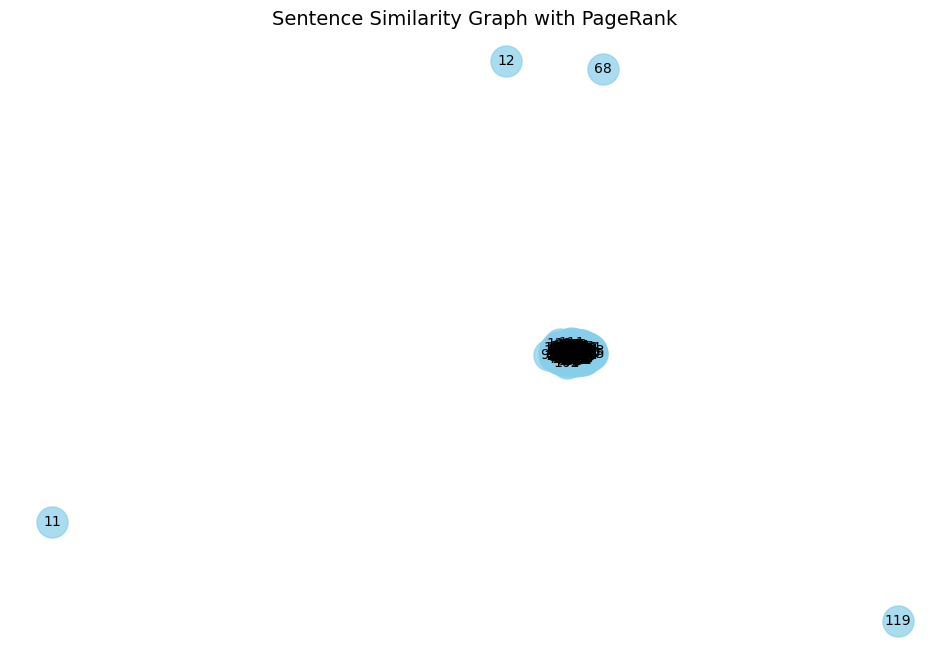

In [20]:
!pip install matplotlib

import matplotlib.pyplot as plt
import networkx as nx

# Build graph from similarity matrix (already done)
nx_graph = nx.from_numpy_array(sim_mat)

# Apply PageRank to get sentence importance scores
scores = nx.pagerank(nx_graph)

# Plot the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(nx_graph, seed=42)  # Positioning of nodes

# Draw nodes, edges, and labels
nx.draw_networkx_nodes(nx_graph, pos, node_color='skyblue', node_size=500, alpha=0.7)
nx.draw_networkx_edges(nx_graph, pos, alpha=0.4)
nx.draw_networkx_labels(nx_graph, pos, {i: str(i) for i in nx_graph.nodes}, font_size=10)

plt.title("Sentence Similarity Graph with PageRank", fontsize=14)
plt.axis('off')
plt.show()


In [14]:
# ✂️ 10. Extract top N sentences for summary
ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(flat_sentences)), reverse=True)

summary = [s for _, s in ranked_sentences[:5]]  # Change 5 to desired number of sentences

# 🖨️ Print summary
print("📝 Generated Summary:\n")
for i, sent in enumerate(summary, 1):
    print(f"{i}. {sent}")


📝 Generated Summary:

1. Reid recalled.If I hadnt got sick, I think I could have started pushing towards the second week at the slams and then who knows. Duringa comeback attempt some five years later, Reid added Bernard Tomic and 2018 US Open Federer slayer John Millman to his list of career scalps.
2. Major players feel that a big event in late November combined with one in January before the Australian Open will mean too much tennis and too little rest.
3. So I'm not the one to strike up a conversation about the weather and know that in the next few minutes I have to go and try to win a tennis match.
4. Speaking at the Swiss Indoors tournament where he will play in Sundays final against Romanian qualifier Marius Copil, the world number three said that given the impossibly short time frame to make a decision, he opted out of any commitment.
5. Exhausted after spending half his round deep in the bushes searching for my ball, as well as those of two other golfers hed never met bef